In [73]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# General imports
import numpy as np
import os

# Plotting
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

# ML imports
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [75]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [76]:
# Data parameters
N = 10**6
mu = 0.1
sigma = 1

In [77]:
### Generate the data.

# Background is Normal(-μ, 1)
# Signal is Normal(μ, 1))
bkgd = np.random.normal(-mu, sigma, N)
sgnl = np.random.normal(mu, sigma, N)
X = np.concatenate([bkgd, sgnl])
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [78]:
# Loss functions
def bce(y_true, y_pred):
    return -((y_true) * K.log(y_pred + K.epsilon()) + (1. - y_true) * K.log(1. - y_pred))

def mse(y_true, y_pred):
    return -((y_true) * -K.square(1. - y_pred) + (1. - y_true) * -K.square(y_pred + K.epsilon()))

def mlc(y_true, y_pred):
    return -((y_true) * K.log(y_pred + K.epsilon()) + (1. - y_true) * (1. - y_pred))

def square_mlc(y_true, y_pred):
    return -((y_true) * K.log(y_pred**2) + (1. - y_true) * (1. - y_pred**2))

def exp_mlc(y_true, y_pred):
    return -((y_true) * y_pred + (1. - y_true) * (1. - K.exp(y_pred)))

def square_sqr(y_true, y_pred):
    return -((y_true) * -1. / K.sqrt(K.square(y_pred)) + (1. - y_true) * -K.sqrt(K.square(y_pred)))

def exp_sqr(y_true, y_pred):
    return -((y_true) * -1. / K.sqrt(K.exp(y_pred)) + (1. - y_true) * -K.sqrt(K.exp(y_pred)))

def sqr(y_true, y_pred):
    return -((y_true) * -1. / K.sqrt(y_pred + K.epsilon()) + (1. - y_true) * -K.sqrt(y_pred + K.epsilon()))

def get_sqr(a):
    def sqr_a(y_true, y_pred):
        return -((y_true) * -K.pow(y_pred + K.epsilon(), -a/2) + (1. - y_true) * -K.pow(y_pred + K.epsilon(), a/2))
    return sqr_a
        
# Likelihood ratios
def lr(x):
    return np.exp(-(1/(2 * sigma**2)) * ( (x - mu)**2 - (x + mu)**2))

def get_bce_lr(model):
    def model_bce_lr(x):
        f = model.predict(x)
        return np.squeeze(f / (1. - f))
    return model_bce_lr

def get_mse_lr(model):
    def model_mse_lr(x):
        f = model.predict(x)
        return np.squeeze(f / (1. - f))
    return model_mse_lr

def get_mlc_lr(model):
    def model_mlc_lr(x):
        f = model.predict(x)
        return np.squeeze(f)
    return model_mlc_lr

def get_square_mlc_lr(model):
    def model_square_mlc_lr(x):
        f = model.predict(x)
        return np.squeeze(f**2)
    return model_square_mlc_lr

def get_exp_mlc_lr(model):
    def model_exp_mlc_lr(x):
        f = model.predict(x)
        return np.squeeze(np.exp(f))
    return model_exp_mlc_lr

def get_sqr_lr(model):
    def model_sqr_lr(x):
        f = model.predict(x)
        return np.squeeze(f)
    return model_sqr_lr

def get_square_sqr_lr(model):
    def model_square_sqr_lr(x):
        f = model.predict(x)
        return np.squeeze(f**2)
    return model_square_sqr_lr

def get_exp_sqr_lr(model):
    def model_exp_sqr_lr(x):
        f = model.predict(x)
        return np.squeeze(np.exp(f))
    return model_exp_sqr_lr

def mae(model_lr):
    # Takes in model_lr, a model likelihood ratio. Returns the expected absolute
    # error for that model.
    return np.abs(model_lr(X) - lr(X)).mean()

In [79]:
earlystopping = EarlyStopping(patience=10,
                              verbose=0,
                              restore_best_weights=True)

In [80]:
# Models
def train(loss, 
          hidden='relu', 
          output='sigmoid', 
          dropout=True, 
          optimizer='adam', 
          metrics=['accuracy'], 
          verbose=0):
    model = Sequential()
    if dropout:
        model.add(Dense(64, activation=hidden, input_shape=(1, )))
        model.add(Dropout(0.1))
        model.add(Dense(128, activation=hidden))
        model.add(Dropout(0.1))
        model.add(Dense(64, activation=hidden))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation=output))
    else: 
        model.add(Dense(64, activation=hidden, input_shape=(1, )))
        model.add(Dense(128, activation=hidden))
        model.add(Dense(64, activation=hidden))
        model.add(Dense(1, activation=output))        
    
    model.compile(loss=loss,
                  optimizer=optimizer, 
                  metrics=metrics)
    
    trace = model.fit(X_train, 
                      y_train,
                      epochs = 100, 
                      batch_size=int(0.1*N), 
                      validation_data=(X_test, y_test),
                      callbacks=[earlystopping], 
                      verbose=verbose)
    print(trace.history['val_loss'][-1], end = ' ')
    
    lr_match = {bce: get_bce_lr, 
                mse: get_mse_lr, 
                mlc: get_mlc_lr,
                square_mlc: get_square_mlc_lr,
                exp_mlc: get_exp_mlc_lr,
                sqr: get_sqr_lr, 
                square_sqr: get_square_sqr_lr, 
                exp_sqr: get_exp_sqr_lr}
    if loss in lr_match.keys():
        model_lr = lr_match[loss](model)
    else:
        model_lr = get_sqr_lr(model)
    
    return model, model_lr

def create_model(loss, 
                 hidden='relu', 
                 output='sigmoid', 
                 dropout=True, 
                 optimizer='adam', 
                 metrics=['accuracy']):
    model = Sequential()
    model.add(Dense(64, activation=hidden, input_shape=(1, )))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation=hidden))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation=hidden))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation=output))
    return model

In [81]:
# Plotting functions
def get_preds(model_lrs, xs=np.linspace(-6, 6, 1000)):
    # Takes in model_lrs, a list of model likelihood ratios and xs, a list of 
    # values on which to compute the likelihood ratios. Returns a 2D array. The 
    # nth row is the likelihood ratio predictions from the nth model in 
    # model_lrs.
    return np.array([model_lr(xs) for model_lr in model_lrs])
    
def avg_lr(preds):
    # Takes in a 2D array of multiple models' likelihood ratio predictions. 
    # Returns the average likelihood ratio prediction and its error.
    return preds.mean(axis=0), preds.std(axis=0)

def avg_lrr(preds, xs=np.linspace(-6, 6, 1000)):
    # Takes in a 2D array of multiple models' likelihood ratio predictions. 
    # Returns the average ratio of predicted likelihood to true likelihood and 
    # its error.
    lrr_preds = preds / lr(xs)
    return lrr_preds.mean(axis=0), lrr_preds.std(axis=0)
    
def lr_plot(ensembles,
            filename=None,
            cs = ['brown', 'green', 'red', 'blue'],
            lss = [':', '--', '-.', ':'],
            xs=np.linspace(-6, 6, 1000)):
    # Takes in a list of pairs (lr_avg, lr_err). Plots them against the true 
    # likelihood.
    fig, ax_1 = plt.subplots(figsize = (10, 6))
    
    # Plot true likelihood
    plt.plot(xs, lr(xs), label = 'Exact', c='k', ls='-')
    
    # Plot model likelihoods
    for i in range(len(ensembles)):
        avg, err, lbl = ensembles[i]
        plt.plot(xs, avg, label=lbl, c=cs[i], ls=lss[i])
        plt.fill_between(xs, avg - err, avg + err, color=cs[i], alpha=0.1)
    plt.legend()
    ax_1.minorticks_on()
    ax_1.tick_params(direction='in', which='both',length=5)
    plt.ylabel('Likelihood Ratio')

    # Plot background and signal
    ax_2 = ax_1.twinx()
    bins = np.linspace(-6, 6, 100)
    plt.hist(sgnl, alpha=0.1, bins=bins)
    plt.hist(bkgd, alpha=0.1, bins=bins)
    ax_2.minorticks_on()
    ax_2.tick_params(direction='in', which='both',length=5)
    plt.ylabel('Count')

    plt.xlim(-6, 6)
    plt.xlabel(r'$x$')
    plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
    if filename != None:
        plt.savefig(filename, dpi=1200, bbox_inches='tight')

def lrr_plot(ensembles,
             filename=None,
             cs = ['brown', 'green', 'red', 'blue'],
             lss = [':', '--', '-.', ':'],
             xs=np.linspace(-6, 6, 1000)):
    # Takes in a list of pairs (lrr_avg, lrr_err). Plots them.
    fig, ax_1 = plt.subplots(figsize = (10, 6))
    
    # Plot ratios of likelihood ratios
    for i in range(len(ensembles)):
        avg, err, lbl = ensembles[i]
        plt.plot(xs, avg, label=lbl, c=cs[i], ls=lss[i])
        plt.fill_between(xs, avg - err, avg + err, color=cs[i], alpha=0.1)
    plt.axhline(1,ls=":",color="grey", lw=0.5)
    plt.axvline(0,ls=":",color="grey", lw=0.5)
    plt.legend()
    ax_1.minorticks_on()
    ax_1.tick_params(direction='in', which='both',length=5)
    plt.ylim(0.94, 1.06)
    plt.ylabel('Ratio')

    # Plot background and signal
    ax_2 = ax_1.twinx()
    bins = np.linspace(-6, 6, 100)
    plt.hist(sgnl, alpha=0.1, bins=bins)
    plt.hist(bkgd, alpha=0.1, bins=bins)
    ax_2.minorticks_on()
    ax_2.tick_params(direction='in', which='both',length=5)
    plt.ylabel('Count')

    plt.xlim(-6, 6)
    plt.xlabel(r'$x$')
    plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20)
    if filename != None:
        plt.savefig(filename, dpi=1200, bbox_inches='tight')
    
#_plot(model_lrs):

# SQR Parametrizations

In [ ]:
reps = 10

# create losses
a_list = np.linspace(-2, 2, 100)
lrs = {}
for a in a_list:
    print('===================================================\n{}'.format(a))
    lrs[a] = [None] * reps
    loss = get_sqr(a)
    param = {'loss': loss, 'output':'relu'}
    for i in range(10):
        print(i, end = ' ')
        model, lrs[a][i] = train(**param)
        model.save_weights('models/sqr/sqr_model_{}_{}.h5'.format(a, i))
        print()

-2.0
0 0.9964730739593506 
1 0.9954530000686646 
2 0.9958760142326355 
3 1.0124329328536987 
4 0.9956911206245422 
5 0.9973122477531433 
6 0.9969468712806702 
7 0.9964625835418701 
8 0.9973077774047852 
9 0.9959608912467957 
-1.9595959595959596
0 0.9959594011306763 
1 

# Reweighting Schemes

In [ ]:
reps = 100

# model parameters
params_1 = {'loss':mlc, 'hidden':'relu', 'output':'relu'}
params_2 = {'loss':square_mlc, 'hidden':'relu', 'output':'linear'}
params_3 = {'loss':exp_mlc, 'hidden':'relu', 'output':'linear'}

In [ ]:
%%time

models_1 = [None] * reps
models_2 = [None] * reps
models_3 = [None] * reps

lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    models_1[i], lrs_1[i] = train(**params_1)
    models_2[i], lrs_2[i] = train(**params_2)
    models_3[i], lrs_3[i] = train(**params_3)
    print()

In [ ]:
for i in range(reps):
    models_1[i].save_weights('models/ratios/mlc/mlc_model_{}.h5'.format(i))
    models_2[i].save_weights('models/ratios/mlc/square_mlc_model_{}.h5'.format(i))
    models_3[i].save_weights('models/ratios/mlc/exp_mlc_model_{}.h5'.format(i))

In [ ]:
# Get average predictions and errors. Add on the labels to 
# make plotting easier.
lr_1 = avg_lr(get_preds(lrs_1)) + ('linear',)
lr_2 = avg_lr(get_preds(lrs_2)) + ('square',)
lr_3 = avg_lr(get_preds(lrs_3)) + ('exponential',)

lrr_1 = avg_lrr(get_preds(lrs_1)) + ('linear',)
lrr_2 = avg_lrr(get_preds(lrs_2)) + ('square',)
lrr_3 = avg_lrr(get_preds(lrs_3)) + ('exponential',)

In [ ]:
lr_plot([lr_1, lr_2, lr_3], 'plots/mlc_param_lr.png')

In [ ]:
lrr_plot([lrr_1, lrr_2, lrr_3], 'plots/mlc_param_lrrs.png')

# Error Calculations

In [ ]:
reps = 100

bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'hidden':'relu', 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

Ns = 10**np.arange(2, 9)

In [ ]:
%%time

bce_models = {}
bce_lrs = {}
for N in Ns:
    print('===================================================\n{}'.format(N))
    bce_models[N] = [None] * reps
    bce_lrs[N] = [None] * reps
    
    # Generate data
    bkgd = np.random.normal(-mu, 1, N)
    sgnl = np.random.normal(mu, 1, N)
    X = np.concatenate([bkgd, sgnl])
    y = np.concatenate([np.zeros(N), np.ones(N)])

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    for i in range(reps):
        print(i, end = ' ')
        bce_models[N][i], bce_lrs[N][i] = train(**bce_params)
        print()

In [ ]:
# Calculate mean absolute errors.

N = 10**4

bkgd = np.random.normal(-mu, 1, N)
sgnl = np.random.normal(mu, 1, N)
X = np.concatenate([bkgd, sgnl])

bce_mae_avg = []
bce_mae_err = []
for N in Ns:
    bce_maes = [mae(lr) for lr in bce_lrs[N]]
    
    bce_mae_avg += [np.mean(bce_maes)]
    bce_mae_err += [np.std(bce_maes)]

bce_mae_avg = np.array(bce_mae_avg)
bce_mae_err = np.array(bce_mae_err)

In [ ]:
for N in Ns:
    for i in range(reps):
        bce_models[N][i].save_weights('models/maes/bce/bce_model_{}_{}.h5'.format(N, i))

np.save('lr_data/bce_mae_avg.npy', bce_mae_avg)
np.save('lr_data/bce_mae_err.npy', bce_mae_err)

In [ ]:
%%time

bce_models = {}
mse_models = {}
mlc_models = {}
sqr_models = {}

bce_lrs = {}
mse_lrs = {}
mlc_lrs = {}
sqr_lrs = {}

for N in Ns:
    print('===================================================\n{}'.format(N))
    # Set up lists
    bce_models[N] = [None] * reps
    mse_models[N] = [None] * reps
    mlc_models[N] = [None] * reps
    sqr_models[N] = [None] * reps
    
    bce_lrs[N] = [None] * reps
    mse_lrs[N] = [None] * reps
    mlc_lrs[N] = [None] * reps
    sqr_lrs[N] = [None] * reps
    
    # Generate data
    bkgd = np.random.normal(-mu, 1, N)
    sgnl = np.random.normal(mu, 1, N)
    X = np.concatenate([bkgd, sgnl])
    y = np.concatenate([np.zeros(N), np.ones(N)])

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    for i in range(reps):
        print(i, end = ' ')
        bce_lrs[N][i] = train(**bce_params)[1]
        mse_lrs[N][i] = train(**mse_params)[1]
        mlc_lrs[N][i] = train(**mlc_params)[1]
        sqr_lrs[N][i] = train(**sqr_params)[1]
        print()

In [ ]:
# Calculate mean absolute errors.

N = 10**3

bkgd = np.random.normal(-mu, 1, N)
sgnl = np.random.normal(mu, 1, N)
X = np.concatenate([bkgd, sgnl])

bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

bce_mae_err = []
mse_mae_err = []
mlc_mae_err = []
sqr_mae_err = []

for N in Ns:
    bce_maes = [mae(lr) for lr in bce_lrs[N]]
    mse_maes = [mae(lr) for lr in mse_lrs[N]]
    mlc_maes = [mae(lr) for lr in mlc_lrs[N]]
    sqr_maes = [mae(lr) for lr in sqr_lrs[N]]
    
    bce_mae_avg += [np.mean(bce_maes)]
    bce_mae_err += [np.std(bce_maes)]
    mse_mae_avg += [np.mean(mse_maes)]
    mse_mae_err += [np.std(mse_maes)]
    
    mlc_mae_avg += [np.mean(mlc_maes)]
    mlc_mae_err += [np.std(mlc_maes)]
    
    sqr_mae_avg += [np.mean(sqr_maes)]
    sqr_mae_err += [np.std(sqr_maes)]

bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

bce_mae_err = np.array(bce_mae_err)
mse_mae_err = np.array(mse_mae_err)
mlc_mae_err = np.array(mlc_mae_err)
sqr_mae_err = np.array(sqr_mae_err)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(Ns, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(Ns, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(Ns, mlc_mae_avg, c='red', ls='--', label='MLC')
plt.plot(Ns, sqr_mae_avg, c='blue', ls='-.', label='SQR')
plt.fill_between(Ns, bce_mae_avg - bce_mae_err, bce_mae_avg + bce_mae_err, color='brown', alpha=0.1)
plt.fill_between(Ns, mse_mae_avg - mse_mae_err, mse_mae_avg + mse_mae_err, color='green', alpha=0.1)
plt.fill_between(Ns, mlc_mae_avg - mlc_mae_err, mlc_mae_avg + mlc_mae_err, color='red', alpha=0.1)
plt.fill_between(Ns, sqr_mae_avg - sqr_mae_err, sqr_mae_avg + sqr_mae_err, color='blue', alpha=0.1)
plt.legend()

plt.xscale("log", base=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
plt.savefig('plots/maes.png', dpi=1200, bbox_inches='tight')

# Neural Network Training

In [ ]:
reps = 10

# Parameters to compare
params_1 = {'loss':sqr, 'hidden':'relu', 'output':'relu'}
params_2 = {'loss':sqr, 'hidden':'relu', 'output':'elu'}
params_3 = {'loss':sqr, 'hidden':'elu', 'output':'relu'}
params_4 = {'loss':sqr, 'hidden':'elu', 'output':'elu'}

In [ ]:
%%time

models_1 = [None] * reps
models_2 = [None] * reps
models_3 = [None] * reps
models_4 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    models_1[i] = train(**params_1)[1]
    models_2[i] = train(**params_2)[1]
    models_3[i] = train(**params_3)[1]
    models_4[i] = train(**params_4)[1]
    print()

In [ ]:
# Get average predictions and errors. Add on the labels to 
# make plotting easier.
sqr_lr_1 = avg_lr(get_preds(models_1)) + ('ReLU/ReLU',)
sqr_lr_2 = avg_lr(get_preds(models_2)) + ('ReLU/ELU',)
sqr_lr_3 = avg_lr(get_preds(models_3)) + ('ELU/ReLU',)
sqr_lr_4 = avg_lr(get_preds(models_4)) + ('ELU/ELU',)

sqr_lrr_1 = avg_lrr(get_preds(models_1)) + ('ReLU/ReLU',)
sqr_lrr_2 = avg_lrr(get_preds(models_2)) + ('ReLU/ELU',)
sqr_lrr_3 = avg_lrr(get_preds(models_3)) + ('ELU/ReLU',)
sqr_lrr_4 = avg_lrr(get_preds(models_4)) + ('ELU/ELU',)

In [ ]:
lr_plot([sqr_lr_1, sqr_lr_2, sqr_lr_3, sqr_lr_4], 'plots/sqr_lr_comparisons.png')

In [ ]:
lrr_plot([sqr_lrr_1, sqr_lrr_2, sqr_lrr_3, sqr_lrr_4], 'plots/sqr_lrr_comparisons.png')

In [ ]:
xs = np.linspace(-6, 6, 1000)

sqr_lrs_1 = np.array([sqr_lr(xs) for sqr_lr in models_1[100:200]])
sqr_lrs_2 = np.array([sqr_lr(xs) for sqr_lr in models_2[100:200]])
sqr_lrs_3 = np.array([sqr_lr(xs) for sqr_lr in models_3[100:200]])
sqr_lrs_4 = np.array([sqr_lr(xs) for sqr_lr in models_4[100:200]])

lrr_1 = sqr_lrs_1 / lr(xs)
lrr_2 = sqr_lrs_2 / lr(xs)
lrr_3 = sqr_lrs_3 / lr(xs)
lrr_4 = sqr_lrs_4 / lr(xs)

lrr_bar_1 = lrr_1.mean(axis=0)
lrr_bar_2 = lrr_2.mean(axis=0)
lrr_bar_3 = lrr_3.mean(axis=0)
lrr_bar_4 = lrr_4.mean(axis=0)

lrr_err_1 = lrr_1.std(axis=0)
lrr_err_2 = lrr_2.std(axis=0)
lrr_err_3 = lrr_3.std(axis=0)
lrr_err_4 = lrr_4.std(axis=0)

In [ ]:
plt.plot(xs, lrr_bar_1, label = 'relu/relu', c = 'brown', ls=':')
plt.plot(xs, lrr_bar_2, label = 'relu/elu', c = 'green', ls='--')
plt.plot(xs, lrr_bar_3, label = 'elu/relu', c = 'blue', ls='-.')
plt.plot(xs, lrr_bar_4, label = 'elu/elu', c = 'red', ls='--')
plt.fill_between(xs, lrr_bar_1 - lrr_err_1, lrr_bar_1 + lrr_err_1, color='brown', alpha=0.1)
plt.fill_between(xs, lrr_bar_2 - lrr_err_2, lrr_bar_2 + lrr_err_2, color='green', alpha=0.1)
plt.fill_between(xs, lrr_bar_3 - lrr_err_3, lrr_bar_3 + lrr_err_3, color='blue', alpha=0.1)
plt.fill_between(xs, lrr_bar_4 - lrr_err_4, lrr_bar_4 + lrr_err_4, color='red', alpha=0.1)
plt.axhline(1,ls=":",color="grey", lw=0.5)
plt.axvline(0,ls=":",color="grey", lw=0.5)
plt.legend()
plt.savefig('plots/sqr_cmp.png')

In [ ]:
dmaef mae(data):
    return np.abs(data - lr(xs)).sum(axis=1).mean(axis=0)

mae(sqr_lrs_1), mae(sqr_lrs_2), mae(sqr_lrs_3), mae(sqr_lrs_4)

In [ ]:
1/0

In [ ]:
plt.plot(xs, lr(xs), c='k', label='exact')
plt.plot(xs, bce_rs_mean, c='green', label='relu/relu')
plt.plot(xs, bce_es_mean, c='red', label='elu/elu')

plt.fill_between(xs, bce_rs_mean - bce_rs_err, bce_rs_mean + bce_rs_err, color='green', alpha=0.1)
plt.fill_between(xs, bce_es_mean - bce_es_err, bce_es_mean + bce_es_err, color='red', alpha=0.1)
plt.legend();
plt.ylim(0, 4)
plt.savefig('plots/avg_lr_mlc_ee_rr_2.png', dpi=1200, bbox_inches='tight')

In [ ]:
plt.plot(xs, bce_rs_mean / lr(xs), c='green', label='relu/relu')
plt.plot(xs, bce_es_mean / lr(xs), c='red', label='elu/elu')
plt.fill_between(xs, bce_rsr_mean - bce_rsr_err, bce_rsr_mean + bce_rsr_err, color='green', alpha=0.1)
plt.fill_between(xs, bce_esr_mean - bce_esr_err, bce_esr_mean + bce_esr_err, color='red', alpha=0.1)

#plt.ylim(0.5, 1.5)
plt.legend();
plt.savefig('plots/avg_lrr_mlc_eerr_1.png', dpi=1200, bbox_inches='tight')

In [ ]:
mlc_rs_maes = []
mlc_es_maes = []

# This should be a sum
for i in range(100):
    model_mlc_lr = get_mlc_lr(bce_rs_models[i])
    mlc_rs_maes += [np.mean(np.abs(model_mlc_lr(X) - lr(X)))]
    
    model_mlc_lr = get_mlc_lr(bce_es_models[i])
    mlc_es_maes += [np.mean(np.abs(model_mlc_lr(X) - lr(X)))]

# Plot MAEs over time.

In [ ]:
# Data parameters
N = 10**3
mu = 0.1
sigma = 1

In [ ]:
### Generate the data.

# Background is Normal(-μ, 1)
# Signal is Normal(μ, 1))
bkgd = np.random.normal(-mu, sigma, N)
sgnl = np.random.normal(mu, sigma, N)
X = np.concatenate([bkgd, sgnl])
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
def mae(model_lr):
    # Takes in model_lr, a model likelihood ratio. Returns the expected absolute
    # error for that model.
    return np.abs(model_lr(X) - lr(X)).mean()

In [ ]:
Ns = 10**np.arange(2, 8)

In [ ]:
reps = 100

In [ ]:
bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

bce_mae_err = []
mse_mae_err = []
mlc_mae_err = []
sqr_mae_err = []

for N in Ns:
    print(N)
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        filename = 'models/maes/bce/bce_model_{}_{}.h5'.format(N, i)
        bce_model = create_model(**bce_params)
        bce_model.load_weights(filename)
        bce_lrs[i] = get_bce_lr(bce_model)

        filename = 'models/maes/mse/mse_model_{}_{}.h5'.format(N, i)
        mse_model = create_model(**mse_params)
        mse_model.load_weights(filename)
        mse_lrs[i] = get_mse_lr(mse_model)

        filename = 'models/maes/mlc/mlc_model_{}_{}.h5'.format(N, i)
        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(filename)
        mlc_lrs[i] = get_exp_mlc_lr(mlc_model)

        filename = 'models/maes/sqr/sqr_model_{}_{}.h5'.format(N, i)
        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(filename)
        sqr_lrs[i] = get_sqr_lr(sqr_model)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_mae_avg += [np.mean(bce_maes)]
    bce_mae_err += [np.std(bce_maes)]
    mse_mae_avg += [np.mean(mse_maes)]
    mse_mae_err += [np.std(mse_maes)]
    
    mlc_mae_avg += [np.mean(mlc_maes)]
    mlc_mae_err += [np.std(mlc_maes)]
    
    sqr_mae_avg += [np.mean(sqr_maes)]
    sqr_mae_err += [np.std(sqr_maes)]

bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

bce_mae_err = np.array(bce_mae_err)
mse_mae_err = np.array(mse_mae_err)
mlc_mae_err = np.array(mlc_mae_err)
sqr_mae_err = np.array(sqr_mae_err)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(Ns, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(Ns, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(Ns, mlc_mae_avg, c='red', ls='--', label='MLC')
#plt.plot(Ns, sqr_mae_avg, c='blue', ls='-.', label='SQR')
plt.fill_between(Ns, bce_mae_avg - bce_mae_err, bce_mae_avg + bce_mae_err, color='brown', alpha=0.1)
plt.fill_between(Ns, mse_mae_avg - mse_mae_err, mse_mae_avg + mse_mae_err, color='green', alpha=0.1)
plt.fill_between(Ns, mlc_mae_avg - mlc_mae_err, mlc_mae_avg + mlc_mae_err, color='red', alpha=0.1)
#plt.fill_between(Ns, sqr_mae_avg - sqr_mae_err, sqr_mae_avg + sqr_mae_err, color='blue', alpha=0.1)
plt.legend()
plt.ylim(0, 0.12)

plt.xscale("log", basex=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
plt.savefig('plots/maes_without_sqr.png', dpi=1200, bbox_inches='tight')

## Plot different reweighting schemes

We'll use $N = 10^6$. 

In [ ]:
filename = 'models/maes/bce/bce_model_1000000_0.h5'
bce = create_model(**bce_params)
bce.load_weights(filename)

In [ ]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(100):
    filename = 'models/maes/bce/bce_model_1000000_{}.h5'.format(i)
    bce_model = create_model(**bce_params)
    bce_model.load_weights(filename)
    bce_lrs[i] = get_bce_lr(bce_model)
    
    filename = 'models/maes/mse/mse_model_1000000_{}.h5'.format(i)
    mse_model = create_model(**mse_params)
    mse_model.load_weights(filename)
    mse_lrs[i] = get_mse_lr(mse_model)
    
    filename = 'models/maes/mlc/mlc_model_1000000_{}.h5'.format(i)
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(filename)
    mlc_lrs[i] = get_exp_mlc_lr(mlc_model)
    
    filename = 'models/maes/sqr/sqr_model_1000000_{}.h5'.format(i)
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(filename)
    sqr_lrs[i] = get_sqr_lr(sqr_model)

In [ ]:
bce_lr = avg_lr(get_preds(bce_lrs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs)) + ('SQR',)

bce_lrr = avg_lrr(get_preds(bce_lrs)) + ('BCE',)
mse_lrr = avg_lrr(get_preds(mse_lrs)) + ('MSE',)
mlc_lrr = avg_lrr(get_preds(mlc_lrs)) + ('MLC',)
sqr_lrr = avg_lrr(get_preds(sqr_lrs)) + ('SQR',)

In [ ]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 'plots/lr_schemes.png')

In [ ]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 'plots/lrr_schemes.png')

In [ ]:
bce_mae = np.mean([mae(lr) for lr in bce_lrs])
mse_mae = np.mean([mae(lr) for lr in mse_lrs])
mlc_mae = np.mean([mae(lr) for lr in mlc_lrs])
sqr_mae = np.mean([mae(lr) for lr in sqr_lrs])

In [ ]:
print(bce_mae, mse_mae, mlc_mae, sqr_mae)

# Compare SQR losses

In [25]:
reps = 100

# model parameters
params_1 = {'loss':sqr, 'hidden':'relu', 'output':'relu'}
params_2 = {'loss':square_sqr, 'hidden':'relu', 'output':'linear'}
params_3 = {'loss':exp_sqr, 'hidden':'relu', 'output':'linear'}

In [26]:
%%time

models_1 = [None] * reps
models_2 = [None] * reps
models_3 = [None] * reps

lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    models_1[i], lrs_1[i] = train(**params_1)
    models_2[i], lrs_2[i] = train(**params_2)
    models_3[i], lrs_3[i] = train(**params_3)
    print()

0 0.9951449036598206 1.4107364416122437 0.9950249195098877 
1 0.9951347708702087 0.9953994750976562 0.9949960708618164 
2 0.9951592683792114 1.0008858442306519 0.9950171113014221 
3 0.9950721263885498 1.1917601823806763 0.9950727224349976 
4 0.9950897693634033 5.027225971221924 0.9951675534248352 
5 0.9954094290733337 2.9690747261047363 0.9950169920921326 
6 0.995124876499176 1.0048434734344482 0.9951153993606567 
7 0.9951351284980774 1.1726341247558594 0.9950603246688843 
8 0.9950090646743774 13.181309700012207 0.9950352311134338 
9 0.9953133463859558 1.0660783052444458 0.995079517364502 
10 0.9950881004333496 1.401214838027954 0.9950275421142578 
11 0.9951295256614685 1.1551522016525269 0.9950204491615295 
12 0.9952492713928223 0.995853841304779 0.9950482249259949 
13 0.9954487681388855 1.006528377532959 0.995058000087738 
14 0.9951618313789368 28.784582138061523 0.995113730430603 
15 0.995281994342804 1.0110543966293335 0.995126485824585 
16 0.9951419830322266 0.9966252446174622 0.9

In [27]:
for i in range(reps):
    models_1[i].save_weights('models/ratios/sqr/sqr_model_{}.h5'.format(i))
    models_2[i].save_weights('models/ratios/sqr/square_sqr_model_{}.h5'.format(i))
    models_3[i].save_weights('models/ratios/sqr/exp_sqr_model_{}.h5'.format(i))

In [28]:
# Get average predictions and errors. Add on the labels to 
# make plotting easier.
lr_1 = avg_lr(get_preds(lrs_1)) + ('linear',)
lr_2 = avg_lr(get_preds(lrs_2)) + ('square',)
lr_3 = avg_lr(get_preds(lrs_3)) + ('exponential',)

lrr_1 = avg_lrr(get_preds(lrs_1)) + ('linear',)
lrr_2 = avg_lrr(get_preds(lrs_2)) + ('square',)
lrr_3 = avg_lrr(get_preds(lrs_3)) + ('exponential',)

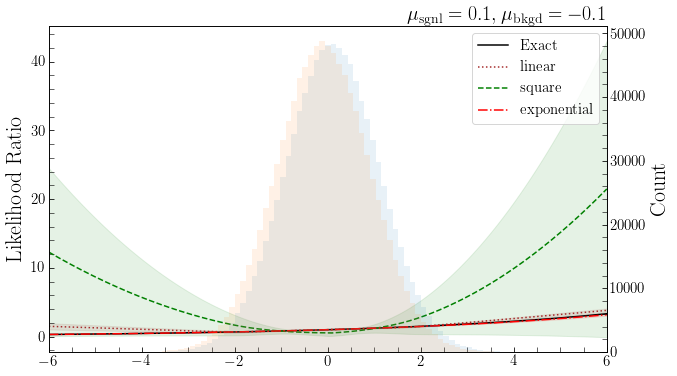

In [29]:
lr_plot([lr_1, lr_2, lr_3], 'plots/sqr_param_lr.png')

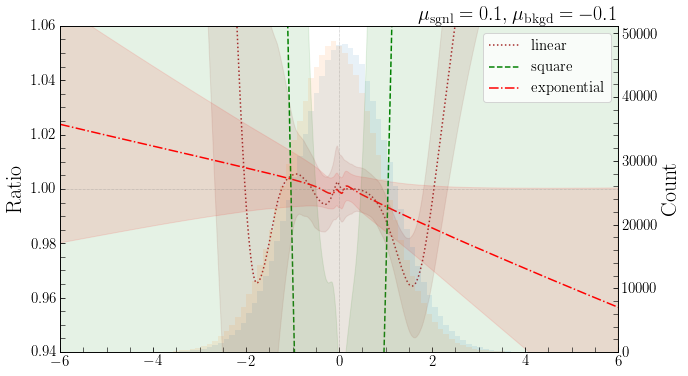

In [30]:
lrr_plot([lrr_1, lrr_2, lrr_3], 'plots/sqr_param_lrrs.png')

# Ensemble Learning

In [ ]:
1/0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Lambda, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.models import Model
    
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import gridspec
from matplotlib import patches

plt.rcParams["font.family"] = "serif"

In [ ]:
#MLC loss

N = 100000

theta0 = 0.1

X_MC = np.random.normal(-theta0,1,N)
X_data = np.random.normal(theta0,1,N)
X_MLE_train, X_MLE_val, Y_MLE_train, Y_MLE_val = train_test_split(np.concatenate([X_data,X_MC]), np.concatenate([np.ones(len(X_data)),np.zeros(len(X_MC))]), test_size=0.5)


def CustomLoss2(y_true, y_pred):
    return -y_true*K.log(y_pred**2+0.00000001) + (1.-y_true)*y_pred**2

def CustomLoss(y_true, y_pred):
    return -y_true*K.log(y_pred+0.00000001) + (1.-y_true)*y_pred

model_MLE2 = Sequential()
model_MLE2.add(Dense(64, activation='relu',input_shape =(1,))) 
model_MLE2.add(Dense(128, activation='relu'))
model_MLE2.add(Dense(64, activation='relu'))
model_MLE2.add(Dense(1, activation='linear')) #was sigmoid
model_MLE2.compile(loss=lambda y_true, y_pred: CustomLoss2(y_true, y_pred), optimizer='adam', metrics=['accuracy'])
hist_MLE2 = model_MLE2.fit(X_MLE_train, Y_MLE_train, epochs=100, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val),callbacks=[earlystopping])

model_MLE = Sequential()
model_MLE.add(Dense(64, activation='relu',input_shape =(1,))) 
model_MLE.add(Dense(128, activation='relu'))
model_MLE.add(Dense(64, activation='relu'))
model_MLE.add(Dense(1, activation='relu')) #was sigmoid
model_MLE.compile(loss=lambda y_true, y_pred: CustomLoss(y_true, y_pred), optimizer='adam', metrics=['accuracy'])
hist_MLE = model_MLE.fit(X_MLE_train, Y_MLE_train, epochs=100, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val),callbacks=[earlystopping])

model_BCE = Sequential()
model_BCE.add(Dense(64, activation='relu',input_shape =(1,))) 
model_BCE.add(Dense(128, activation='relu'))
model_BCE.add(Dense(64, activation='relu'))
model_BCE.add(Dense(1, activation='sigmoid'))
model_BCE.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
hist_BCE = model_BCE.fit(X_MLE_train, Y_MLE_train, epochs=100, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val),callbacks=[earlystopping])


In [ ]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax1 = plt.subplot(gs[0])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax1.minorticks_on()

xx = np.linspace(-3,3,100)
preds_BCE = model_BCE.predict(xx)
plotBCE = plt.plot(xx,preds_BCE/(1.-preds_BCE),label="NN (BCE)",ls=":",lw=5,color='green')
preds_test2 = model_MLE2.predict(xx)**2
plot12 = plt.plot(xx,preds_test2,label="NN (MLC, squared)",ls=":",color='green')
preds_test = model_MLE.predict(xx)
plot11 = plt.plot(xx,preds_test,label="NN (MLC, linear)",ls="-",color='green')
plot2 = plt.plot(xx,np.exp(-((xx-theta0)**2-(xx+theta0)**2)/(2*1**2)),label="exact",color='orange')
plt.ylim([0,2])
plt.axvline(0,ls=":",color="grey")
plt.axhline(1,ls=":",color="grey")
plt.xlabel(r"$x$",fontsize=20)
plt.ylabel("likelihood ratio",fontsize=20)
plt.title(r"$\mu_{MC} = "+str(theta0)+r", \mu_{data}=0.5$",loc="right",fontsize=20)

ax2 = ax1.twinx()
_,_,_=plt.hist(X_MLE_train[Y_MLE_train==0],bins=np.linspace(-3,3,50),alpha=0.3,label="Back.",color='red')
_,_,_=plt.hist(X_MLE_train[Y_MLE_train==1],bins=np.linspace(-3,3,50),alpha=0.3,label="Signal")
ax2.tick_params(axis='y', labelcolor="red")
ax2.set_ylabel("histogram",color='red',fontsize=20)

for label in ax2.yaxis.get_majorticklabels():
        label.set_fontsize(20)

leg = plt.legend([plotBCE[0], plot11[0],plot12[0],plot2[0]],['BCE', 'MLC, linear','MLC, squared','Exact'], loc="upper left",frameon=False,fontsize=18)
plt.legend(frameon=False,fontsize=20)
plt.gca().add_artist(leg)

#plt.savefig("ensembleLearnPlots/MLCloss.pdf",bbox_inches='tight')